<h2>Predicting Firefly luciferase inhibitors</h2>
<br>
The data I used for this project are available at the National Center for Biotechnology Information on PubChem under AID 411 (https://pubchem.ncbi.nlm.nih.gov/bioassay/411). <br>
In this dataset 72,000 different small molecules were tested for their potential to inhibit firefly luciferase from Photinus pyralis. <br><br>

The project is divided into four parts: Data cleaning, visualization, model training and evaluation<br><br>

In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np

# Import data file "PubChem AID 411"
# Only following columns are neccesary:
# PUBCHEM_CID
# PUBCHEM_ACTIVITY_OUTCOME
# PUBCHEM_ACTIVITY_SCORE
df = pd.read_csv('AID_411_datatable_all.csv', sep=',', 
                 skiprows=(lambda x: x in range(1, 6)), 
                 encoding = 'ISO-8859-1')

df = df.filter(['PUBCHEM_CID',
                'PUBCHEM_ACTIVITY_OUTCOME',
                'PUBCHEM_ACTIVITY_SCORE'], axis=1)

print(df.shape)
df.head(5)

(72359, 3)


,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE
0,6603008.0,Inactive,0
1,6602571.0,Inactive,0
2,6602616.0,Inactive,0
3,644371.0,Inactive,0
4,6603132.0,Inactive,0


In [2]:
# There are missing values in some rows of 'PUBCHEM_CID'
df[df.PUBCHEM_CID.isnull()]

,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE
43562,NaN,Inactive,0
43667,NaN,Inactive,0
43677,NaN,Inactive,0
44135,NaN,Inactive,0
44518,NaN,Inactive,0
44519,NaN,Inactive,0
44520,NaN,Inactive,0
44521,NaN,Inactive,0
44522,NaN,Inactive,0
44523,NaN,Inactive,0


In [3]:
# 25 CIDs are missing. Since they are all inactive we just delete them.

df['PUBCHEM_CID'].replace('', np.nan, inplace=True)
df.dropna(subset=['PUBCHEM_CID'], inplace=True)

print(df.shape)

(72334, 3)


                          PUBCHEM_CID  PUBCHEM_ACTIVITY_SCORE
PUBCHEM_ACTIVITY_OUTCOME                                     
Active                           1577                    1577
Inactive                        70072                   70072
Inconclusive                      685                     685


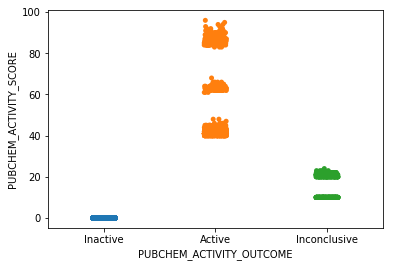

In [4]:
# Get some information about the outcome and the distribution of the data

import seaborn as sns

print(df.groupby('PUBCHEM_ACTIVITY_OUTCOME').count());
sns.stripplot(x='PUBCHEM_ACTIVITY_OUTCOME', y='PUBCHEM_ACTIVITY_SCORE', data=df, jitter=True);

In [5]:
# Create y based on PUBCHEM_ACTIVITY_OUTCOME
# Molecules with 'inconclusive' output are droped, because putting them into the 'active' ones
# would maybe generate a lot of false-positives and putting them into the 'inactive' group
# we would unintentionally generate false-negatives. Both scenarios would make predictions even harder. 

# Drop 'Inconclusive' molecules
df.drop(df[df.PUBCHEM_ACTIVITY_OUTCOME =='Inconclusive'].index, inplace=True)
print(df.shape)

# Set y according to activity outcome
y = np.where(df['PUBCHEM_ACTIVITY_OUTCOME']=='Active', '1', '0')
y = y.astype(int)

print(y.shape)

(71649, 3)
(71649,)


In [6]:
# After cleaning the data and genearting target vector y, we need SMILES representation
# of the molecules based on CIDs to featurize molecules later

import pubchempy as pcp

CIDs = list(np.array(df['PUBCHEM_CID'].values).astype(int))

df_SMILES = pd.DataFrame()

df_SMILES = pcp.get_properties(['isomeric_smiles', ], CIDs , namespace='cid', as_dataframe=True)

df_SMILES.shape   

(71649, 1)

In [ ]:
df_SMILES.head(5)

In [8]:
# Clean SMILES string. Sometimes counter ions or accompanying substances are included.
# Usually these accompanying substances are on second place and the molecules from interest
# is on first place. They are splittet by '.'

df.insert(loc=2, column='SMILES', value=df_SMILES.values)

for i in df.index:
    df.at[i, 'SMILES'] = df.at[i, 'SMILES'].rsplit('.', 1)[0]

df.head(5)

,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,SMILES,PUBCHEM_ACTIVITY_SCORE
0,6603008.0,Inactive,CCOCCCNCC(=O)NC1=CC=C(C=C1)OC(F)(F)F,0
1,6602571.0,Inactive,COCCN1C(=NN=N1)CN2CCC(CC2)CC3=CC=CC=C3,0
2,6602616.0,Inactive,COCCN1C(=NN=N1)CN2CCC(CC2)(C3=CC(=CC=C3)C(F)(F...,0
3,644371.0,Inactive,C1CCCN(CC1)CC(=O)NCCC2=CC=C(C=C2)F,0
4,6603132.0,Inactive,COC1=CC=C(C=C1)C(=O)C(C2=CC=CC=C2)N3CCOCC3,0


In [9]:
# Featurize SMILES

# Available Featurizer by DeppChem:
# ConvMolFeaturizer
# WeaveFeaturizer
# CircularFingerprint
# RDKitDescriptors
# CoulombMatrix
# CoulombMatrixEig
# BPSymmetryFunction
# AdjacencyFingerprint



import warnings; warnings.simplefilter('ignore')
import deepchem as dc

df.SMILES.to_csv('data_tmp.csv', header=True)

def featurize_SMILES (dataset_file, smiles_field, featurizer_func):
    loader = dc.data.CSVLoader(tasks=[], smiles_field=smiles_field, 
                               featurizer=featurizer_func, log_every_n=10000)
    dataset = loader.featurize(dataset_file)
    return pd.DataFrame(dataset.X)

df_features = featurize_SMILES('data_tmp.csv', 'SMILES', dc.feat.CircularFingerprint())
df_features.head(5)

Instructions for updating:
Use the retry module or similar alternatives.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from data_tmp.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 87.511 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 122.795 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from imblearn.over_sampling import RandomOverSampler 

cnn = RandomOverSampler(random_state=42) 
X_res, y_res = cnn.fit_sample(df_features, y)

print(X_res.shape, y_res.shape)

(140144, 2048) (140144,)


In [14]:
import warnings; warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard

test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=test_size, 
                                                    stratify=y_res, random_state=42)


# For a single-input model with 2 classes (binary classification):
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
Dropout(0.2, noise_shape=None, seed=None)
model.add(Dense(256, activation='relu'))
Dropout(0.2, noise_shape=None, seed=None)
model.add(Dense(256, activation='relu'))
Dropout(0.2, noise_shape=None, seed=None)
model.add(Dense(32, activation='relu'))
Dropout(0.2, noise_shape=None, seed=None)
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'categorical_accuracy',])

#This is for model evaluation via Tensorboard
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, 
                         write_graph=True, write_images=True, write_grads = 100)

# Train the model, iterating on the data in batches of 32 samples
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, 
          verbose=1, callbacks=[tbCallBack])

model.evaluate(X_test, y_test)

Using TensorFlow backend.


Train on 78480 samples, validate on 19620 samples
Epoch 1/10
78480/78480 [==============================] - 622s 8ms/step - loss: 0.1132 - acc: 0.9597 - categorical_accuracy: 1.0000 - val_loss: 0.0423 - val_acc: 0.9906 - val_categorical_accuracy: 1.0000
Epoch 2/10
78480/78480 [==============================] - 637s 8ms/step - loss: 0.0267 - acc: 0.9928 - categorical_accuracy: 1.0000 - val_loss: 0.0345 - val_acc: 0.9912 - val_categorical_accuracy: 1.0000
Epoch 3/10
78480/78480 [==============================] - 6041s 77ms/step - loss: 0.0141 - acc: 0.9962 - categorical_accuracy: 1.0000 - val_loss: 0.0297 - val_acc: 0.9939 - val_categorical_accuracy: 1.0000
Epoch 4/10
78480/78480 [==============================] - 531s 7ms/step - loss: 0.0123 - acc: 0.9974 - categorical_accuracy: 1.0000 - val_loss: 0.0420 - val_acc: 0.9926 - val_categorical_accuracy: 1.0000
Epoch 5/10
78480/78480 [==============================] - 535s 7ms/step - loss: 0.0087 - acc: 0.9981 - categorical_accuracy: 1.0000 

[0.02228178760868362, 0.9957425554181334, 1.0]

[[20875   147]
 [   32 20990]]


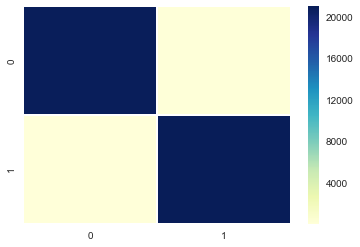

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

y_pred = model.predict_classes(X_test)
data = confusion_matrix(y_test, y_pred)

print(data)

sns.heatmap((data), 
            annot=False, fmt="f", 
            linewidths=.5, cmap="YlGnBu");

Oversamplingfactor was roughly 44x: 147/44 = 3. 3 wrong from 1577 molecules and 32 from 20875